In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix


In [3]:
diabetes_df = pd.read_csv('data/diabetes.csv')
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [5]:
# Shortening the name of DiabetesPedigreeFunction
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [6]:
# Checking the proportion of zero values in each of the features 
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


In [7]:
# Changing the zero values to the mean values 
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

In [8]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [61]:
diabetes_df.to_csv('diabetes_clean.csv', index = False)

In [42]:
from pycaret.classification import *

clf1 = setup(data = diabetes_df, 
             target = 'Outcome',
             preprocess = False,
             silent = True)

,Description,Value
0,session_id,181
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Transformed Train Set,"(537, 8)"
9,Transformed Test Set,"(231, 8)"


In [43]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [44]:
top5 = compare_models(sort='AUC',
                      n_select = 5
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7635,0.8353,0.6345,0.6916,0.6518,0.4750,0.4836,0.0150
lda,Linear Discriminant Analysis,0.7671,0.8262,0.5450,0.7451,0.6204,0.4594,0.4768,0.0030
rf,Random Forest Classifier,0.7392,0.8256,0.5769,0.6557,0.5973,0.4107,0.4199,0.0320
lr,Logistic Regression,0.7690,0.8253,0.5450,0.7515,0.6225,0.4633,0.4815,0.3350
et,Extra Trees Classifier,0.7449,0.8176,0.5716,0.6724,0.6099,0.4241,0.4321,0.0290
ada,Ada Boost Classifier,0.7336,0.8130,0.6135,0.6373,0.6187,0.4154,0.4208,0.0120
lightgbm,Light Gradient Boosting Machine,0.7412,0.8088,0.6035,0.6493,0.6206,0.4256,0.4299,0.0780
qda,Quadratic Discriminant Analysis,0.7505,0.8070,0.5561,0.6904,0.6098,0.4304,0.4402,0.0030
nb,Naive Bayes,0.7449,0.7999,0.6035,0.6577,0.6222,0.4315,0.4379,0.0030
knn,K Neighbors Classifier,0.7356,0.7713,0.5982,0.6377,0.6141,0.4142,0.4169,0.2270


In [45]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.8526,0.5789,0.6111,0.5946,0.3836,0.3839
1,0.7963,0.8827,0.6316,0.7500,0.6857,0.5367,0.5410
2,0.6667,0.7158,0.5789,0.5238,0.5500,0.2863,0.2872
3,0.8333,0.8827,0.7895,0.7500,0.7692,0.6389,0.6394
4,0.7037,0.7925,0.5263,0.5882,0.5556,0.3344,0.3355
5,0.7407,0.8346,0.7368,0.6087,0.6667,0.4577,0.4633
6,0.7778,0.8887,0.6842,0.6842,0.6842,0.5128,0.5128
7,0.6981,0.8127,0.5556,0.5556,0.5556,0.3270,0.3270
8,0.6226,0.7229,0.4211,0.4706,0.4444,0.1601,0.1606


In [46]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.7969, precision: 0.7586, recall: 0.6377,    F1: 0.6929, AUC:0.8654


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

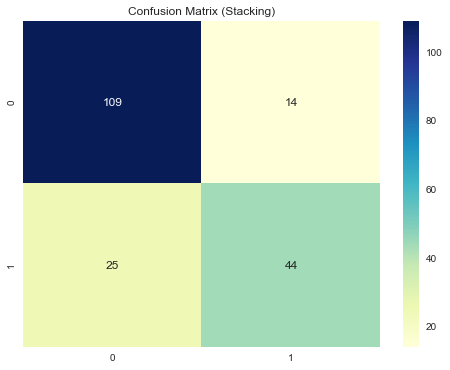

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [48]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8677,0.5789,0.6875,0.6286,0.4524,0.4561
1,0.8148,0.9023,0.6842,0.7647,0.7222,0.5840,0.5860
2,0.6667,0.7143,0.4737,0.5294,0.5000,0.2512,0.2520
3,0.8333,0.9143,0.7895,0.7500,0.7692,0.6389,0.6394
4,0.7222,0.7880,0.4737,0.6429,0.5455,0.3520,0.3605
5,0.6852,0.7925,0.6316,0.5455,0.5854,0.3338,0.3361
6,0.8333,0.9248,0.5789,0.9167,0.7097,0.6010,0.6322
7,0.7736,0.8286,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7358,0.7632,0.5263,0.6667,0.5882,0.3977,0.4037


In [49]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9167, precision: 0.9206, recall: 0.8406,    F1: 0.8788, AUC:0.9525


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

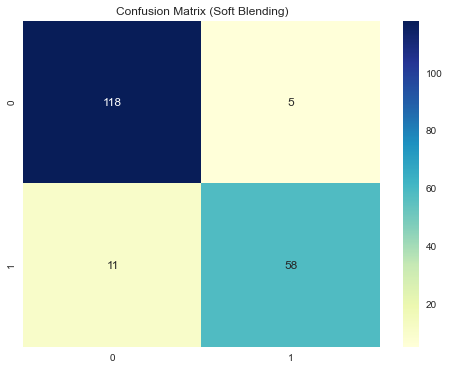

In [50]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

In [51]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.0000,0.6842,0.6842,0.6842,0.5128,0.5128
1,0.8333,0.0000,0.7368,0.7778,0.7568,0.6301,0.6307
2,0.6852,0.0000,0.5263,0.5556,0.5405,0.3014,0.3016
3,0.8148,0.0000,0.7895,0.7143,0.7500,0.6035,0.6054
4,0.6852,0.0000,0.4211,0.5714,0.4848,0.2656,0.2720
5,0.6481,0.0000,0.5789,0.5000,0.5366,0.2554,0.2572
6,0.8333,0.0000,0.6316,0.8571,0.7273,0.6112,0.6260
7,0.7736,0.0000,0.6111,0.6875,0.6471,0.4812,0.4830
8,0.7736,0.0000,0.5789,0.7333,0.6471,0.4838,0.4911


In [52]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8958, precision: 0.8889, recall: 0.8116,F1: 0.8485


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

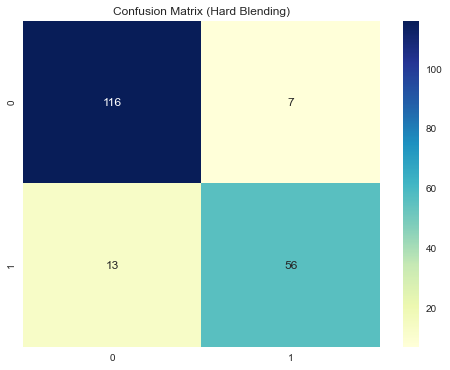

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

In [54]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8662,0.5789,0.6875,0.6286,0.4524,0.4561
1,0.8333,0.8992,0.6842,0.8125,0.7429,0.6209,0.6259
2,0.6852,0.7278,0.4737,0.5625,0.5143,0.2839,0.2862
3,0.8333,0.9158,0.7895,0.7500,0.7692,0.6389,0.6394
4,0.7037,0.7865,0.4211,0.6154,0.5000,0.2998,0.3107
5,0.6667,0.7820,0.5789,0.5238,0.5500,0.2863,0.2872
6,0.8519,0.9233,0.6316,0.9231,0.7500,0.6499,0.6736
7,0.7547,0.8254,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7170,0.7693,0.5263,0.6250,0.5714,0.3625,0.3655


In [55]:
final_model = finalize_model(cali_model)

In [56]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9271, precision: 0.9365, recall: 0.8551,F1: 0.8939


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

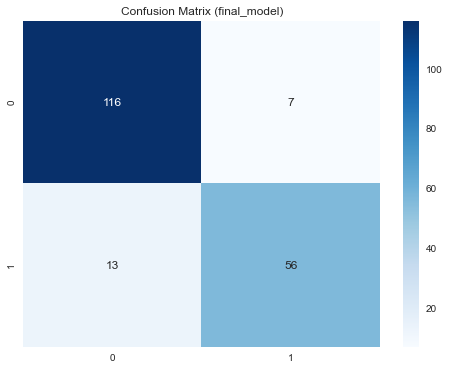

In [59]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')